<a href="https://colab.research.google.com/github/ishanashastri/transformers_from_scratch/blob/main/1_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning Curriculum [Transformers](https://github.com/jacobhilton/deep_learning_curriculum/blob/master/1-Transformers.md)


* What is different architecturally from the Transformer, vs a normal RNN, like an LSTM? (Specifically, how are recurrence and time managed?)
 * *A normal RNN uses BPTT and requires you to keep track of the entire (or some segment of) the past tokens. The Transformer instead processes all tokens in parallel, which means that it requires positional encoding to keep track of which tokens are placed where (since it's not longer sequential), and it no longer requires such massive backprop steps (?)*


* Attention is defined as, Attention(Q,K,V) = softmax(QK^T/sqrt(d_k))V. What are the dimensions for Q, K, and V? Why do we use this setup? What other combinations could we do with (Q,K) that also output weights?
 * *The dimensions are 64 in the original paper. K and V are identical (the input embeddings and post-normalized context-added outputs aka all the possible tokens), and Q is the query/vector to add the context to (aka the current word). Unsure about second question. My guess is that we use this setup to easily linearize the calculations as a form of matrix multiplication? We can also do non scaled dot product, which is just QK or probably any other type of scaling, since our weights are just the application of the scaling Q onto our inputs K TODO FIX*
* Are the dense layers different at each multi-head attention block? Why or why not?
  * *Yes..? I think of it like layers of a CNN. Each learns a different feature set (simplified).*
* Why do we have so many skip connections, especially connecting the input of an attention function to the output? Intuitively, what if we didn't?
  * *Hmm...to avoid overfitting. and information degradation?*

In [1]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def calc_pos_emb(d_model, seq_len):
  '''
    implementation of fixed pos embeddings, could have easily done learned embeddings using nn.Embedding

    d_model: embedding dimension (how many dimensions to represent each token, larger -> more complexity but more computational cost), made equal so you can sum this and input embedding
    seq_len: sequence length (tracks the positions of the tokens in the sequence, usually length of input sequence or pre-maxed out at 512)
  '''
  positions = torch.empty((1, seq_len, d_model))
  div_term = 10000 ** (torch.arange(0,d_model, 2) / d_model)  # Only for even indices since odds are paired and divided by the same factors (every 2i)
  pos = torch.arange(0, seq_len).unsqueeze(1)  # Positions (seq_len, 1)

  # Apply sin to even indices and cos to odd indices
  positions[:, :, 0::2] = torch.sin(pos / div_term)  # sin for even indices
  positions[:, :, 1::2] = torch.cos(pos / div_term)  # cos for odd indices
  return positions # dim: [seq_len, d_model]

In [3]:
pe = calc_pos_emb(64, 100)
pe.size()

torch.Size([1, 100, 64])

<ipython-input-4-d40f36b8f789>:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  plt.imshow(pe.T.data.numpy()) # gradient display


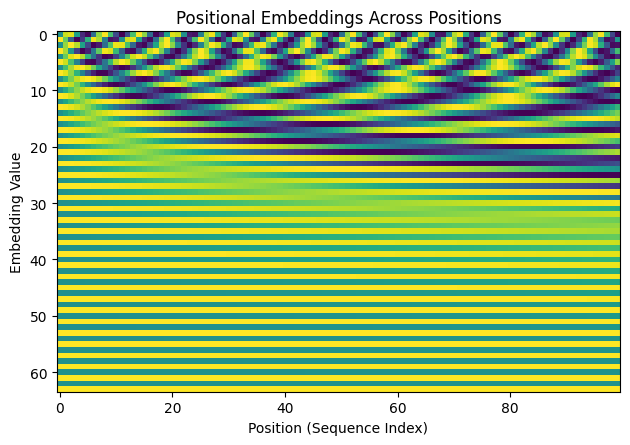

In [4]:
# plt.plot(np.arange(100), pe[:,3:7].data.numpy()) # separate lines
plt.imshow(pe.T.data.numpy()) # gradient display
plt.title("Positional Embeddings Across Positions")
plt.xlabel("Position (Sequence Index)")
plt.ylabel("Embedding Value")
plt.tight_layout()

Each query gets dotted with the array of keys, getting us a [batch_size, seq_len, seq_len] size array that tells us how much each token attends to each other token, computing all pairwise similarities at once. These are all then normalized and softmax-ed across the last dimension, which gives us the same shape but normalizes our distribution into probabilities of each key given each query. Once we multiply this by the values matrix, we get an outputted attention matrix of shape [batch_size, seq_len, d_v]. This output size makes sense because for each of our batches, we want attention scores for each of our input sequence values. The attention values dimension d_v tells us how many numbers will represent our attention score, so we essentially have a vector of length d_v to represent the attention value at each position from 0 to seq_len in our input for that specific input position.

Our input $X$ is of shape [batch_size, seq_len, d_model] (which matches our positional encoding size). Note that the size of the embedding space actually does not affect the attention scores at all. That is because the point of attention is to inject positional relational information into our original sequence in order to preserve word-word contextual information across our seq_len. The embedding is only relevant when we actually construct our $Q, K, V$ matrices by multiplying their respective weight matrices by $X$.

Later on in multi-headed attention, we see that each head takes over a different subspace of our embedding d_model, so that our attention mechanism can operate in a smaller dimension. Even then, we don't really care about our d_model during attention, and we only ever need d_k and d_v. After attention is complete, we concatenate heads again to get d_model as our last dimension.

---



In [5]:
def calc_attention(q, k, v, mask=None):
  '''
  Calculate single- or multi-headed attention scores given query, key, and value

  Args:
    q: query (shape: [batch_size, seq_len, d_k] for single headed or [batch_size, h, seq_len, d_k] for multi)
    k: key (shape: [batch_size, seq_len, d_k] for single headed or [batch_size, h, seq_len, d_k] for multi)
    v: value (shape: [batch_size, seq_len, d_v] for single headed or [batch_size, h, seq_len, d_v] for multi)

  Returns [batch_size, seq_len, d_v] size matrix of attention scores
  '''
  d_k = k.size()[-1]
  attention = (q @ k.transpose(-1,-2)) / math.sqrt(d_k)

  if mask is not None:
    attention = attention.masked_fill(mask == float('-inf'), float('-inf'))

  # note: we mask before softmax so that we force the probabilities of the unwanted positions -> 0 so they do not affect the final distributions
  return torch.softmax(attention.float(), dim=-1) @ v

In [6]:
d_k = 64
d_v = 64
batch_size = 2
seq_len = 8
q = torch.rand((batch_size, seq_len, d_k))
k = torch.rand((batch_size, seq_len, d_k))
v = torch.rand((batch_size, seq_len, d_v))

uma = calc_attention(q, k, v)
x = torch.rand((batch_size, seq_len, d_v))
# print(uma)
print(uma.size()) # should be [2, 8, 64]

torch.Size([2, 8, 64])


In [9]:
# sanity check
gt_uma = torch.nn.functional.scaled_dot_product_attention(q, k, v)
torch.allclose(uma, gt_uma)

True

Text(0, 0.5, 'Seq position')

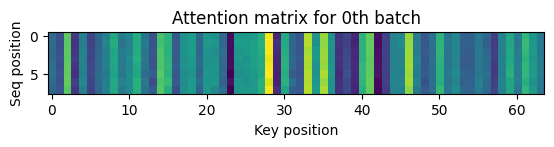

In [10]:
plt.imshow(uma[1,:,:].numpy())
plt.title("Attention matrix for 0th batch")
plt.xlabel("Key position")
plt.ylabel("Seq position")

### Masking

Note that in encoder-decoder models, the encoder can see the entire input (so as to form cross-attention representations) while the decoder is only able to see the previous tokens (so as to learn how to predict the next tokens). Thus, masking is only relevant for the decoder blocks of the model.

In [101]:
def mask(seq_len):
  mask_shape = (1, seq_len, seq_len)
  diag_mask = torch.triu(torch.ones(mask_shape), diagonal=1) # diagonal starts at 1 to represent all words from the next index onwards
  return torch.Tensor(np.where(diag_mask==0., 1.0,float('-inf'))) # invert mask so it only attends to previous words

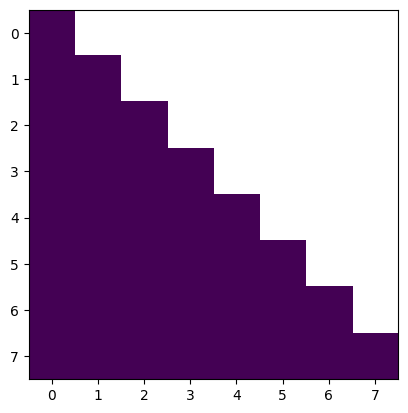

In [12]:
positional_mask = mask(d_model=8)
plt.imshow(positional_mask[0])
# print(positional_mask)

In [13]:
c = calc_attention(q,k,v,mask=positional_mask)

### Attention Block

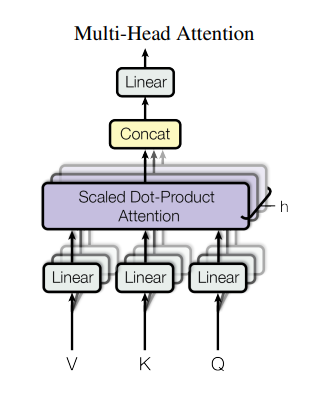

Our attention block consists of $H$ multiple heads which each operate on different subspaces of our input embedding (size $d\_model$). This makes our effective operating dimension of scaled dot-product attention far smaller and more efficient as it is now parallelized since we pass in $d_k = d_v = d\_model/h$ as our key/value/query length instead of $d\_model$. Once attention is complete, we concat all our different heads in order to recombine the disjoint input and return to our original shape in order to pass it through the rest of the model properly. Multi-head attention is just a form of compressing the dimensionality of our queries, keys, and values to make attention more efficient. Note that this is not exactly equivalent to just performing scaled DP attention on our original long input, since each subspace retains different information which is otherwise lost in the averaging of normal DP attention.

In [32]:
import random
random.seed(42)

In [39]:
def multi_head_attention(q, k, v, h, mask=None):
    '''
    Calculate multi-headed attention scores given query, key, value, and number of heads

    Args:
      q: query (shape: [batch_size, seq_len, d_k]) where d_k = d_model
      k: key (shape: [batch_size, seq_len, d_k]) where d_k = d_model
      v: value (shape: [batch_size, seq_len, d_v]) where d_v = d_model
      h: number of heads
      mask: mask to apply to attention scores (optional)

    Returns [batch_size, seq_len, d_v] size matrix of attention scores
    '''

    n_batches = q.size(0)
    d_model = q.size(-1)
    d_k = d_model // h
    seq_len = q.size(-2)

    # everything should be reshaped into h separate heads
    q = q.view(n_batches, seq_len, h, d_k).transpose(1,2) # [batches, h, seq_len, d_k/h], use transpose because the original view splits the last dim of d_model=h*d_k into two dims
    k = k.view(n_batches, seq_len, h, d_k).transpose(1,2) # [batches, h, seq_len, d_k/h]
    v = v.view(n_batches, seq_len, h, d_k).transpose(1,2) # [batches, h, seq_len, d_v/h]

    attention = calc_attention(q, k, v, mask)

    # concat to original size
    attention = attention.view(n_batches, seq_len, d_model)

    # linear
    l = torch.nn.Linear(d_model, d_model) # W^O of size R^{hd_v x d_model}
    out = l(attention)

    return out # [batches, seq_len, d_model]

In [34]:
batch_size = 2
d_k = d_v = d_model = 512
seq_len = 8
h = 8
q = torch.rand((batch_size, seq_len, d_k))
k = torch.rand((batch_size, seq_len, d_k))
v = torch.rand((batch_size, seq_len, d_v))

uma = multi_head_attention(q, k, v, h)
# print(uma)
print(uma.size()) # should be [2, 8, 512] ([batch_size, seq_len, d_model])

True
torch.Size([2, 8, 512])


In [38]:
# sanity check
gt_uma = torch.nn.MultiheadAttention(d_model, h, bias = False, batch_first = True)
torch.allclose(uma, gt_uma(q, k, v)[0])
# note: you can't actually sanity check this without going into the pytorch code because of the weights in the linear layer........

False

Text(0, 0.5, 'Seq position')

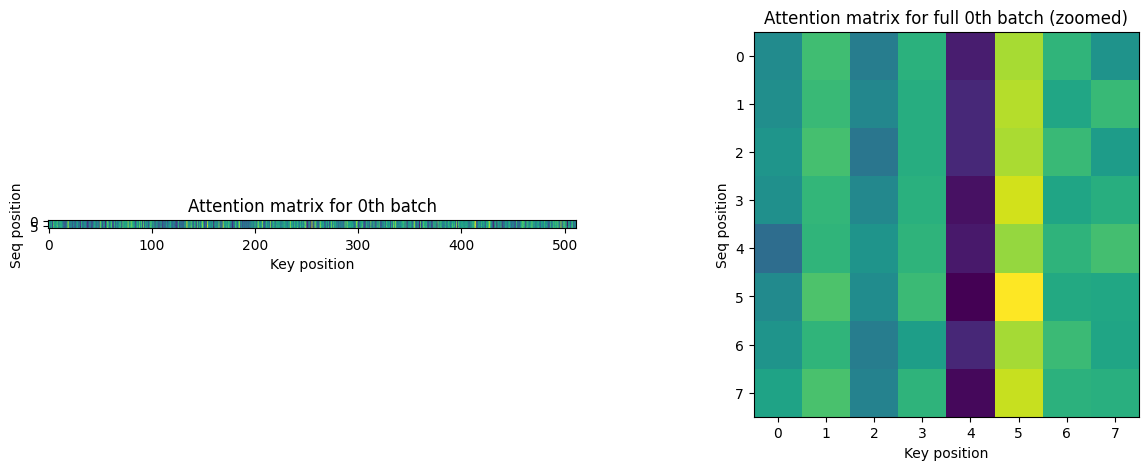

In [216]:
plt.figure(figsize=(15,5))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
ax0.imshow(uma[0,:,:].detach().numpy())
ax0.set_title("Attention matrix for 0th batch")
ax0.set_xlabel("Key position")
ax0.set_ylabel("Seq position")
ax1.imshow(uma[0,:,:8].detach().numpy())
ax1.set_title("Attention matrix for full 0th batch (zoomed)")
ax1.set_xlabel("Key position")
ax1.set_ylabel("Seq position")

### Building the entire decoder block

Our Decoder class represents a SINGLE decoder layer. This layer contains the MHA module, the normalization, and the position-wise FFN.

In [111]:
class Decoder(torch.nn.Module):
  def __init__(self, d_model, h):
    super().__init__()
    self.h = h
    self.d_model = d_model

    self.W_q = torch.nn.Linear(d_model, d_model)
    self.W_k = torch.nn.Linear(d_model, d_model)
    self.W_v = torch.nn.Linear(d_model, d_model)

    self.mha = multi_head_attention
    self.ln1 = torch.nn.LayerNorm(d_model)
    self.ln2 = torch.nn.LayerNorm(d_model)
    self.ff1 = torch.nn.Linear(d_model, 2048)
    self.ff2 = torch.nn.Linear(2048, d_model)
    self.relu = torch.nn.ReLU()

  def forward(self, x):
    """
    x is size [batch, seq_len, d_model], already embedded
    """
    mha = self.mha(self.W_q(x), self.W_k(x), self.W_v(x), self.h, mask=mask(seq_len=x.size(-2)))
    x = self.ln1(mha + x) # residual connection

    ff = self.ff2(self.relu(self.ff1(x))) # position-wise feedforward block
    x = self.ln2(ff + x) # residual connection

    return x

In [112]:
seq_len = 4
d_model = 512
h = 8
decoder = Decoder(d_model, h)

n_layers = 1
vocab = 100
x = torch.nn.Embedding(vocab, d_model)(torch.rand(1, seq_len).to(torch.int64)) # [1, seq_len]

y = decoder.forward(x)
print(f"FINAL DECODER OUTPUT SIZE: {y.size()}") # [1, seq_len, d_model]


FINAL DECODER OUTPUT SIZE: torch.Size([1, 4, 512])


The decoder only transformer creates the embedded input from our given input of size $[1, seq\_len]$, adds the positional encoding, and then passes it through all $n\_layers$ Decoder blocks to get an output of size $[n\_batches, seq\_len, d\_model]$. Then, we pass that through a linear layer to map our decoder output to logits in the vocabulary space, then we softmax along the vocabulary logits dimension to get our final probabilities. Our final output is $[n\_batches, seq\_len, vocab]$ which makes sense as it outputs the probabilities for each next word for each position in the sequence. At first, I was confused why it's of size $seq\_len$ and not just a single prediction for the next word in the sentence, but then I remembered that it's auto-regressive and we end up calculating all next words for all words in the sentence (until some stop sequence), so we see something like this:

```
Input: "Hi my name is"
Output (after max(probability(logits))): "my name is Ishana"
```

In [42]:
class DecoderTransformer(torch.nn.Module):
  def __init__(self, nlayers, vocab, d_model, h):
    super().__init__()
    self.nlayers = nlayers # each layer is a copy of the entire block from MMHA -> Norm -> FFN -> Norm
    self.h = h
    self.d_model = d_model
    self.layers = []

    for n in range(nlayers):
      self.layers.append(Decoder(d_model, h))

    self.layers = torch.nn.ModuleList(self.layers)

    self.embedding = torch.nn.Embedding(vocab, d_model) # LUT from token -> embedding
    self.linear = torch.nn.Linear(d_model, vocab)

  def forward(self, x):
    x = self.embedding(x) + calc_pos_emb(self.d_model, x.size(-1)) # [batch, seq_len, d_model] + [batch, seq_len, d_model]

    for layer in self.layers:
      x = layer.forward(x)

    x = self.linear(x)
    return x


In [106]:
n_layers = 6
vocab = 10
d_model = 512
h = 8
decoder = DecoderTransformer(n_layers, vocab, d_model, h)

n_batches = 1
seq_len = 4
x = torch.rand(n_batches, seq_len).to(torch.int64) # [n_batches, seq_len]
print(f"INPUT SIZE: {x.size()}")
print(f"TOTAL VOCABULARY: {vocab}")

y = decoder.forward(x)
print(f"EXPECTED DECODER OUTPUT SIZE: {[n_batches, seq_len, vocab]}")
print(f"FINAL DECODER OUTPUT SIZE: {y.size()}") # [n_batches, seq_len, vocab]

INPUT SIZE: torch.Size([1, 4])
TOTAL VOCABULARY: 10
EXPECTED DECODER OUTPUT SIZE: [1, 4, 10]
FINAL DECODER OUTPUT SIZE: torch.Size([1, 4, 10])


### Dummy Task Test

Note: we do not use dropout, label smoothing, and a LR scheduler as in the original Vaswani paper.

In [113]:
def generate_copy_data(n_batches, seq_len, vocab):
  """Generate sample input-output pairs for simple dummy tasks."""
  x = torch.randint(0, vocab, (n_batches, seq_len)).to(torch.int64)
  y = x.clone() # uncomment for copy paste task
  # y = torch.stack([torch.flip(i, dims=[-1]) for i in x.clone()], dim=0) # uncomment for reverse string task
  return x, y

In [118]:
n_epochs = 10
n_batches = 32
seq_len = 8
vocab = 10

x,y = generate_copy_data(1000, seq_len, vocab)
trainloader = torch.utils.data.DataLoader(list(zip(x,y)), batch_size=n_batches, shuffle=True)

n_layers = 1
d_model = 512
h = 8
decoder = DecoderTransformer(n_layers, vocab, d_model, h)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.9,0.98), eps=1e-9)

In [119]:
def train():
  losses = []
  accuracy = []
  for _ in tqdm(range(n_epochs)):
    for step, (input, output) in enumerate(trainloader):
      preds = decoder.forward(input)

      # print(f"PRED SIZE: {preds.size()}") # [n_batches, seq_len, vocab]
      # print(f"OUTPUT SIZE: {output.size()}") # [n_batches, seq_len]

      preds = preds.view(-1, vocab) # convert to shape [n_batches, vocab] for loss
      output = output.view(-1) # convert to shape [n_batches]

      optimizer.zero_grad()
      l = loss(preds, output)
      l.backward()
      optimizer.step()

      # print(f"LOSS: {l}")
      losses.append(l.detach().numpy())

      accuracy.append((np.argmax(preds.detach().numpy(), axis=-1) == output.detach().numpy()).mean())
  return decoder, losses, accuracy

In [120]:
model, losses, accuracy = train()

100%|██████████| 10/10 [00:40<00:00,  4.03s/it]


Text(0.5, 1.0, 'Training Loss')

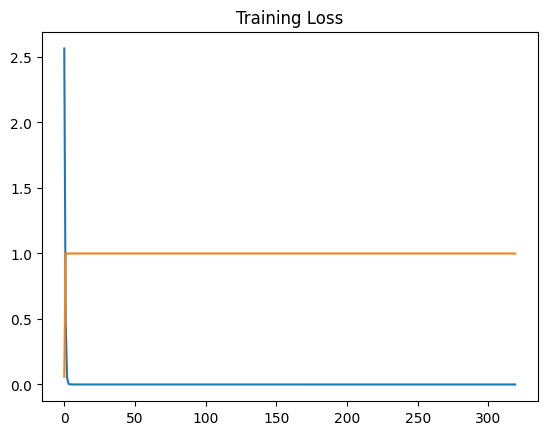

In [121]:
plt.plot(np.arange(len(losses)), losses)
plt.plot(np.arange(len(accuracy)), accuracy)
plt.title("Training Loss")

In [125]:
test_sample = torch.randint(0, vocab, (1, 1, seq_len))
test_sample

tensor([[[0, 9, 7, 2, 4, 7, 5, 4]]])

In [126]:
with torch.no_grad():
  preds = model.forward(test_sample)
  preds = torch.nn.Softmax(dim=-1)(preds)
  pred = np.argmax(preds.detach().numpy(), axis=-1) # returns indices of max probability for each token in the sequence
  print(pred) # for this task, the raw output is what we want since it's effectively already "tokenized" by virtue of just being a number sequence already
  print(f"EQUAL? : {np.allclose(pred, test_sample.detach().numpy())}")

[[[0 9 7 2 4 7 5 4]]]
EQUAL? : True
